[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)

## Paweł Magnuszewski MSc project

## arithmetic Asian call valuation

### Figures: 1, 2

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [1]:
import matplotlib.pyplot as plt
from asian_option import AsianArithmetic, Settings, plot_solution
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from monte_carlo import BSModel, FixedStrikeArithmeticAsianOption
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic

In [158]:
def plot_solution(
    settings,
    frame_index,
    ax,
    history,
    S_linspace,
    arithmetic_by_mc,
    variant,
    s_space_edges
):
    params = {
        k: v for k, v in settings.params.__dict__.items() if not k.startswith("K")
    }
    if variant == "call":
        euro_price_func = Black_Scholes_1973.c_euro
        geometric_price_func = asian_analytic.geometric_asian_average_price_c
    else:
        euro_price_func = Black_Scholes_1973.p_euro
        geometric_price_func = asian_analytic.geometric_asian_average_price_p
    range_lower, range_upper = 80, 120
    s_indexes_within_range = [i for i, v in enumerate(S_linspace) if range_lower<=v<=range_upper]
    # s_indexes_within_range = list(range(len(S_linspace)))
    clipped_s_space = S_linspace[s_indexes_within_range]
    ax.plot(
        clipped_s_space,
        (
            euro_price_func(
                S=clipped_s_space, K=settings.params.K, **params, b=settings.params.r
            )
        ),
        label="European analytic (Black-Scholes '73)",
        linestyle="--",
        alpha=0.5,
        c="black"
    )
    ax.bar(
        s_space_edges[:-1][s_indexes_within_range],
        history[frame_index][:, 0][s_indexes_within_range],
        width=s_space_edges[1:][s_indexes_within_range] - s_space_edges[:-1][s_indexes_within_range],
        alpha=0.3,
        align="edge",
        color="orange"
    )
    ax.plot(
        clipped_s_space,
        history[frame_index][:, 0][s_indexes_within_range],
        label=f"Asian arithmetic MPDATA solution",
        marker=".",
        c="orange"
    )
    ax.plot(
        clipped_s_space,
        arithmetic_by_mc[s_indexes_within_range],
        label="Asian arithmetic by Monte-Carlo",
        marker="+",
        c="blue"
    )
    ax.plot(
        clipped_s_space,
        (
            geometric_price_func(
                S=clipped_s_space, K=settings.params.K, **params, dividend_yield=0
            )
        ),
        label="Asian geometric analytic (Kemna & Vorst 1990)",
        linestyle="--",
        c="green"
    )
    def forward(x):
        return np.interp(x, S_linspace, list(range(len(S_linspace))))
    def inverse(x):
        return np.interp(x, list(range(len(S_linspace))), S_linspace)
    ax2 = ax.secondary_xaxis('top', functions=(forward , inverse))
    ax2.set_xlabel("x/Δx")
    ax2.set_xticks(s_indexes_within_range)
    ax.legend(loc="upper left")
    ax.grid()
    ax.set_xlabel("spot price at t=0 ($)")
    ax.set_ylabel("instrument value ($)")

In [162]:
def run_numeric_and_mc(params, nx=21, ny=31, nt=1000, variant='call'):
    s_max = params.get('S_max', params['spot']*2)
    s_min = params.get('S_min', params['spot']/2)
    settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=s_max, S_min=s_min)
    simulation = AsianArithmetic(settings, nx=nx, ny=ny, nt=nt, variant=variant)
    
    history = []
    for _ in range(simulation.nt):
        _ = simulation.step()
        history.append(simulation.solver.advectee.get().copy())
    arithmetic_by_mc = np.zeros_like(simulation.S)
    for idx, spot in enumerate(simulation.S):
        model = BSModel(spot, settings.params.r, settings.params.sgma, settings.params.T, 1000)
        arithmetic_option = FixedStrikeArithmeticAsianOption(settings.params.T, settings.params.K, variant, model,  100000)
        arithmetic_by_mc[idx], _  = arithmetic_option.price_by_mc()
    s_space_edges = np.exp(np.linspace(np.log(simulation.S[0])-simulation.dx/2, np.log(simulation.S[-1])+simulation.dx/2, nx+1))
    _, ax = pyplot.subplots(1, 1, figsize=(8, 4))
    plot_solution(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  # arithmetic_by_mc=history[-1][:,0],
                  arithmetic_by_mc=arithmetic_by_mc,
                  S_linspace=simulation.S,
                  variant=variant,
                  s_space_edges=s_space_edges)
    show_plot('numeric_vs_analytic.pdf')

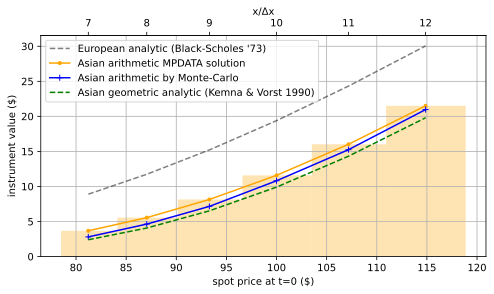

In [163]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.08,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.767,
    }
run_numeric_and_mc(params, nx=21, ny=31, nt=500, variant='call')

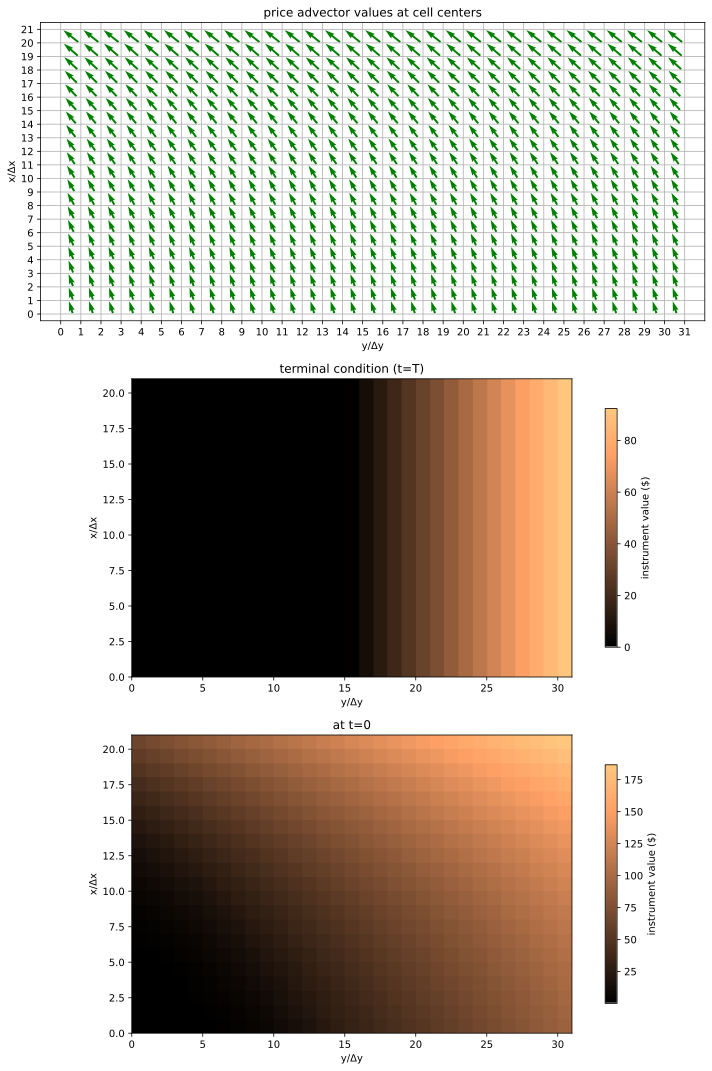

In [161]:
settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=200, S_min=50)
simulation = AsianArithmetic(settings, nx=21, ny=31, nt=500, variant="call")

history = [simulation.solver.advectee.get().copy()]
for i in range(250):
    _ = simulation.step()
history.append(simulation.solver.advectee.get().copy())
for i in range(250):
    _ = simulation.step()
history.append(simulation.solver.advectee.get().copy())

fig, ax = pyplot.subplots(3, 1, figsize=(10,15))

X = simulation.solver.advector.get_component(0)[:-1,:]
Y = simulation.solver.advector.get_component(1)[:,:-1]
grid = (X.shape[1], Y.shape[0])
scale_x, scale_y = np.amax(np.abs(X)), np.amax(np.abs(Y))
ax[0].quiver(*np.mgrid[
        1/2 : grid[0] : 1,
        1/2: grid[1] : 1,
    ], Y.T.flatten()/0.8/scale_y, X.T.flatten()/scale_x, 
             pivot='mid', 
             color='green', 
             width=.003,
             scale=6, 
             scale_units='inches'
)
ax[0].set_title("price advector values at cell centers")
ax[0].set_xlabel('y/Δy')
ax[0].set_ylabel('x/Δx')
for i, xy in enumerate(('x', 'y')):
    getattr(ax[0], f"set_{xy}ticks")(np.arange(0, grid[i] + 1))
ax[0].grid()

im1 = ax[1].imshow(history[0], cmap='copper', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
ax[1].set_title("terminal condition (t=T)")

# im2 = ax[2].imshow(history[1], cmap='copper', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
# ax[2].set_title("at t=T/2")

im3 = ax[2].imshow(history[2], cmap='copper', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
ax[2].set_title("at t=0")

plt.colorbar(im1, ax=ax[1], shrink=0.8, label='instrument value ($)')
plt.colorbar(im2, ax=ax[2], shrink=0.8, label='instrument value ($)')
# plt.colorbar(im3, ax=ax[3], shrink=0.8, label='instrument value ($)')

ax[0].set_xlabel('y/Δy')
ax[1].set_xlabel('y/Δy')
ax[2].set_xlabel('y/Δy')
# ax[3].set_xlabel('y/Δy')
ax[0].set_ylabel('x/Δx')
ax[1].set_ylabel('x/Δx')
ax[2].set_ylabel('x/Δx')
# ax[3].set_xlabel('x/Δx')

fig.tight_layout()

show_plot('advectee_over_time.pdf')